In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

import warnings
warnings.filterwarnings("ignore")

### Time Series EDA

In [169]:
holidays = pd.read_csv("./holidays_events.csv")
oil = pd.read_csv("./oil.csv")
stores = pd.read_csv("./stores.csv")
transactions = pd.read_csv("./transactions.csv")
train = pd.read_csv("./train.csv")

In [170]:
train_merged = train.copy()
train_merged = train_merged.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(holidays, on='date', how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(transactions, on=['store_nbr', 'date'], how='left')
train_merged.rename(columns={'type_x': 'type_store', 'type_y': 'type_holiday'}, inplace=True)
train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,type_holiday,locale,locale_name,description,transferred,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN


In [171]:
train_merged.set_index('date', inplace=True)
average_daily_sales = train_merged.groupby(train_merged.index)["sales"].mean()
average_daily_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Name: sales, dtype: float64

In [172]:
sns.set_style("whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(20, 7),
    titleweight="bold",
    titlesize=18,
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10, 
)

%config InlineBackend.figure_format = "retina" # increase resolution

plot_params = dict(
    style=".-",
    color="0.75",
    markerfacecolor="0.25",
    markeredgecolor="0.25",
)

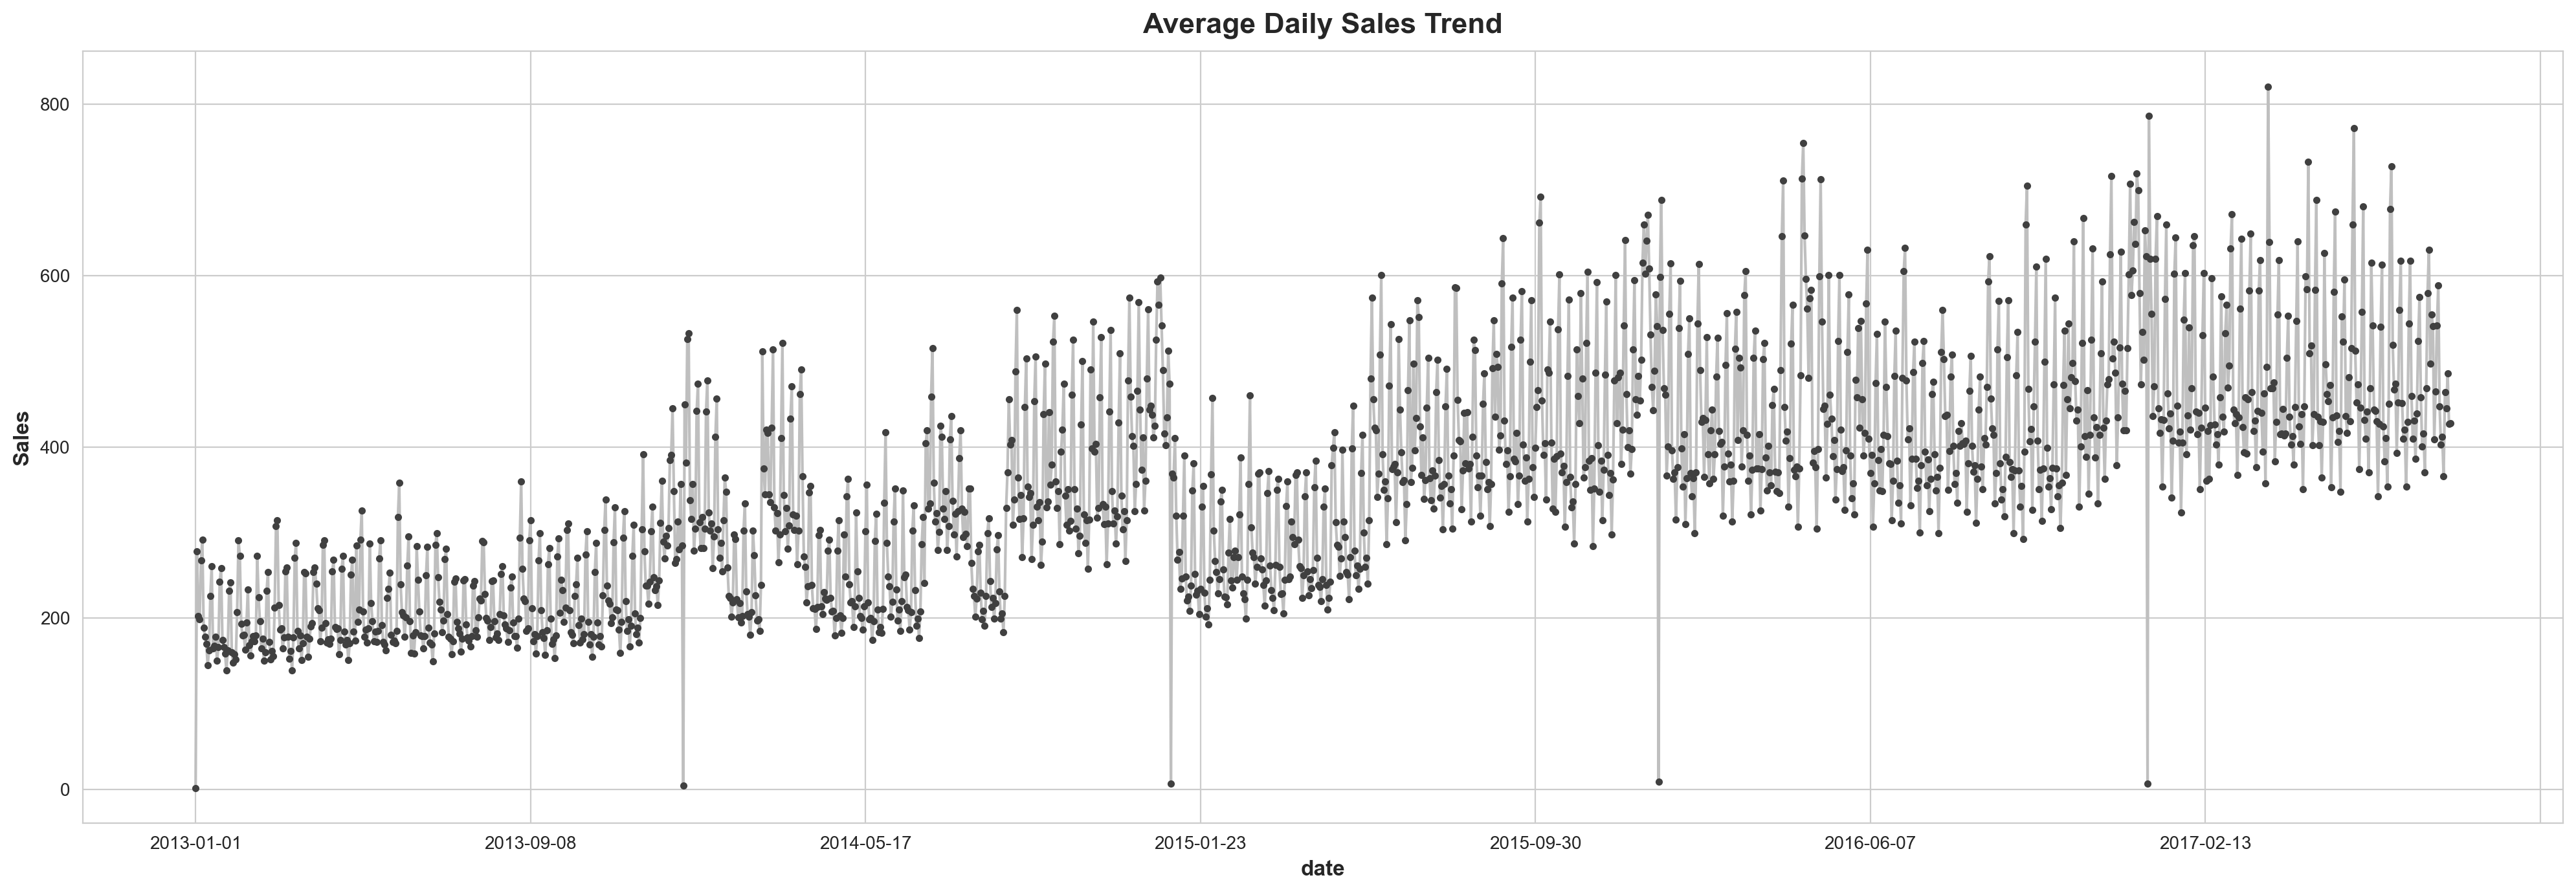

In [173]:
fig, ax = plt.subplots()
average_daily_sales.plot(**plot_params)
ax.set(title="Average Daily Sales Trend", ylabel="Sales");

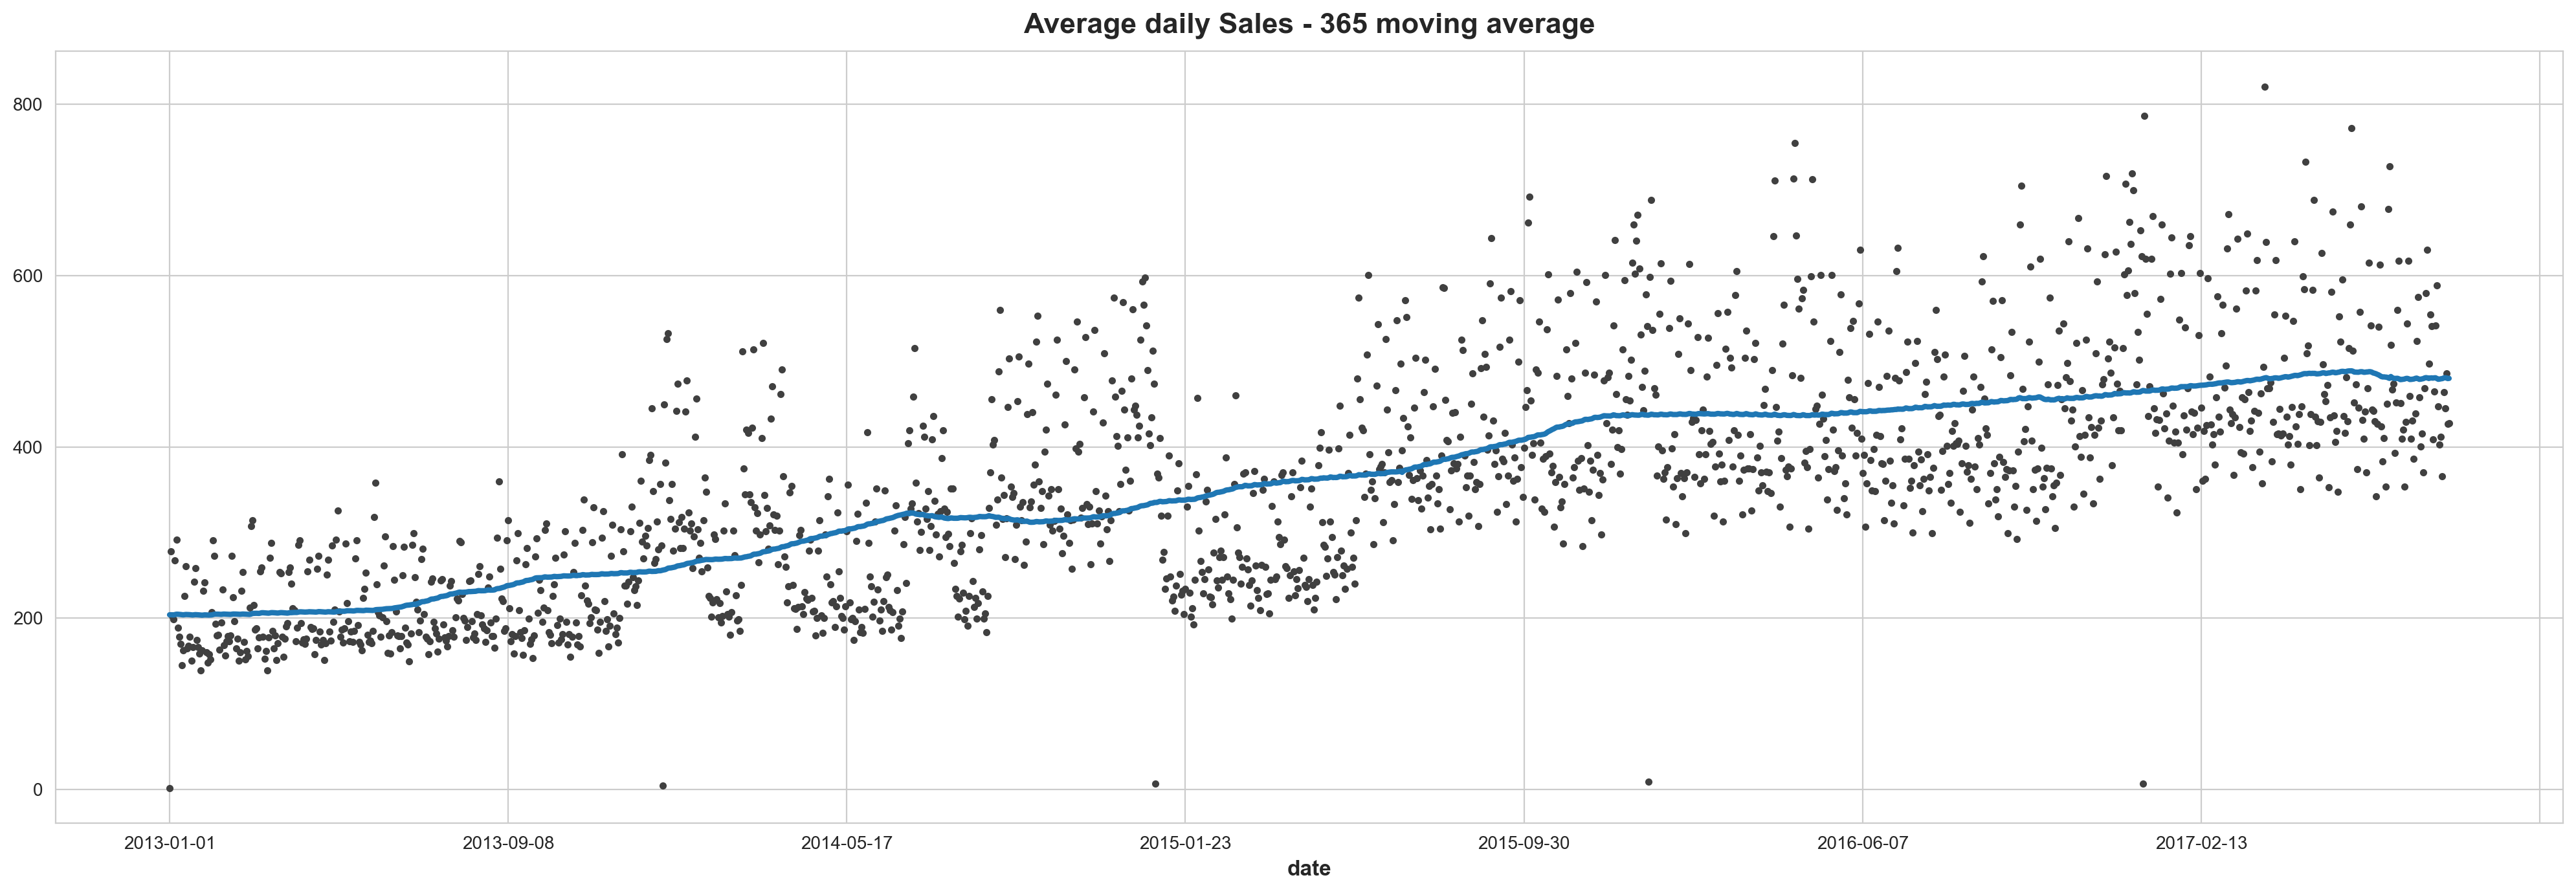

In [174]:
moving_average = average_daily_sales.rolling(
    window=365, # series is daily observations; window size of 365 smooth out short-term fluctuations in series
    min_periods=183, # half of window size is okay. 
    center=True
).mean()
## moving average plot

ax = average_daily_sales.plot(style=".", color="0.25")
moving_average.plot(
                    ax=ax,
                    linewidth=3, 
                    title="Average daily Sales - 365 moving average", 
                    );

### Wrangle Data 
##### 1- read train data and indexing it by 'store_nbr', 'family', 'date'
##### 2- unstacking this group of indexses which means my target will now be very wide table that have the columns of each ('store_nbr', 'family', 'date') combintion
##### 3- Create my input features X using fourier to capture seasonality  

In [155]:
def wrangle_data(train_path:None,test_path:None,oil_path:None,holidays_path:None,transactions_path:None,stores_path:None):
    
    if train_path is not None:
        path = train_path
    else:
        path = test_path 


    df = pd.read_csv(path,
                        usecols=['store_nbr', 'family', 'date', 'sales'],
                        dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                        parse_dates=['date'], infer_datetime_format=True)

    df.date = df.date.dt.to_period('D')
    df = df.set_index(['store_nbr', 'family', 'date']).sort_index()
    ######################################################################
    # Start and end date for training data
    sdate = '2017-01-01'
    edate = '2017-08-15'

    # Create target matrix
    y = df.unstack(['store_nbr', 'family']).loc[sdate:edate]


        
    fourier = CalendarFourier(freq = 'W', order = 4)
    dp = DeterministicProcess(index=y.index,
                            constant=False,
                            order=1,
                            seasonal=False,
                            additional_terms=[fourier],
                            drop=True)
    X = dp.in_sample()

    

    return X,y,dp 

In [156]:
X,y,dp  = wrangle_data(train_path='./train.csv',test_path = None,oil_path='./oil.csv',holidays_path='./holidays_events.csv',transactions_path=None,stores_path=None)
X.head(10)


,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,,
2017-01-01,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-01-02,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-03,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2017-01-04,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-01-05,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-01-06,6.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2017-01-07,7.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
2017-01-08,8.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-01-09,9.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [157]:
X.shape

(227, 7)

In [158]:
y

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...           

In [159]:
# Create class for two algorithms
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [160]:
# Add 'fit' method to the BoostedHybrid class 
def fit(self, X, y):

    self.model_1.fit(X,y)
    y_fit = pd.DataFrame(self.model_1.predict(X),index=X.index, columns=y.columns)
    y_resid = y - y_fit
    self.model_2.fit(X, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns

# Add method to class
BoostedHybrid.fit = fit

In [161]:
def predict(self, X):
    y_pred1 = pd.DataFrame(self.model_1.predict(X),index=X.index, columns=self.y_columns)
    y_pred2 = pd.DataFrame(self.model_2.predict(X),index=X.index, columns=self.y_columns)     
    y_pred = y_pred1 + y_pred2 
    
    return y_pred

# Add method to class
BoostedHybrid.predict = predict

In [162]:
model = BoostedHybrid(                                              
        model_1=Ridge(alpha = 0.5),
        model_2=RandomForestRegressor(n_estimators = 250, random_state = 0))

model.fit(X, y)
y_pred= model.predict(X)
y_pred = y_pred.clip(0.0)
y_pred

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-01   0.770616       0.0  0.090453   343.736265  0.242864    40.631358   
2017-01-02   3.984464       0.0  1.064629  1621.592133  0.203597   235.744851   
2017-01-03   3.836481       0.0  3.259738  2654.434287  1.514085   423.102548   
2017-01-04   2.269506       0.0  3.757402  2892.600298  1.694393   510.503758   
2017-01-05   2.089206       0.0  3.848096  2592.311617  0.421133   501.676605   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   3.283097       0.0  2.410242  1474.381656  0.015337   226.346710   
2017-08-12   5.559795       0.0  3.443966  1843.685061  0.000000   272.312265   
2017-08-13   1.913694       0.0  1.520757   816.323255  0.000000   127.078825   
2017-08-14   2.248784       0.0  5.141633  2059.884758  0.000000   331.783876   
2017-08-15   3.663685       0.0  3.932460  1961.549844  0.093185   320.461125   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-01-01    0.000000   64.603360  105.570163   14.365425  ...  1.901252   
2017-01-02    4.553684  429.540233  476.644213   75.115361  ...  3.088025   
2017-01-03   12.146216  827.952892  861.459024  160.708856  ...  2.599620   
2017-01-04   15.028377  988.307659  992.890393  140.549909  ...  2.949857   
2017-01-05   30.658444  876.425139  853.228218  130.396726  ...  2.220926   
...                ...         ...         ...         ...  ...       ...   
2017-08-11    9.732200  466.853433  483.220884  101.116621  ...  4.400740   
2017-08-12    5.516537  404.152479  574.411997  105.296581  ...  2.979884   
2017-08-13    0.459849  167.506690  261.406033   48.741807  ...  3.405590   
2017-08-14    6.317453  554.031982  657.436314  140.493301  ...  9.123388   
2017-08-15   16.877488  680.370798  600.090882  117.587418  ...  8.807849   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01  232.733559    416.684218     4.263473               11.391505   
2017-01-02  473.244357    860.685892     7.179383               26.302453   
2017-01-03  536.963151    902.778966     6.681781               19.748443   
2017-01-04  442.209289    748.896051     7.175627               16.006808   
2017-01-05  526.574572    612.978423     6.787867               10.649157   
...                ...           ...          ...                     ...   
2017-08-11  298.256180    360.554608     8.932495                2.953621   
2017-08-12  313.395598    479.119946     7.812019               11.092747   
2017-08-13  366.517605    544.897522     5.043558               10.435133   
2017-08-14  329.787683    439.033587     3.107665               10.908633   
2017-08-15  387.980893    468.422991     4.557343                6.182516   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01  333.196328      59.377798  1163.246295                   1.169452   
2017-01-02  582.270715      80.201550  2139.259035                   0.000000   
20

In [163]:
y_pred  = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales']
print('MSLE:', y_target.groupby('family').apply(lambda a: np.sqrt(mean_squared_log_error(a['sales'],a['sales_pred']))).sum())
y_target.groupby('family').apply(lambda a: np.sqrt(mean_squared_log_error(a['sales'],a['sales_pred'])))

MSLE: 11.077204323201013


family
AUTOMOTIVE                    0.262491
BABY CARE                     0.116953
BEAUTY                        0.246216
BEVERAGES                     0.579120
BOOKS                         0.098129
BREAD/BAKERY                  0.419587
CELEBRATION                   0.290024
CLEANING                      0.496750
DAIRY                         0.462611
DELI                          0.372968
EGGS                          0.341197
FROZEN FOODS                  0.335611
GROCERY I                     0.602629
GROCERY II                    0.306242
HARDWARE                      0.242153
HOME AND KITCHEN I            0.307510
HOME AND KITCHEN II           0.257300
HOME APPLIANCES               0.168807
HOME CARE                     0.381701
LADIESWEAR                    0.258824
LAWN AND GARDEN               0.301405
LINGERIE                      0.314590
LIQUOR,WINE,BEER              0.568792
MAGAZINES                     0.243933
MEATS                         0.370265
PERSONAL CARE     

In [164]:
stest = '2017-08-16'
etest = '2017-08-31'

X_test = dp.out_of_sample(steps=16)


   

sales_pred = pd.DataFrame(model.predict(X_test), index = X_test.index,columns = y.columns)  
sales_pred = sales_pred.stack(['store_nbr', 'family'])

In [165]:
df_sub = pd.read_csv('./sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values

In [167]:
df_sub.to_csv('submission.csv', index=True)


In [168]:
df_sub

,sales
id,
3000888,4.263383
3000889,0.000000
3000890,4.208366
3000891,2129.295630
3000892,0.242386
...,...
3029395,269.379656
3029396,105.618939
3029397,1061.161311
